# Fire Detection Using CNN with Weight Optimization

## Importing Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing import image
from datetime import datetime

## Loading Dataset

In [2]:
BASE_DIR = "fire_dataset/"   # rename if different
FIRE_DIR = os.path.join(BASE_DIR, "fire_images")
NONFIRE_DIR = os.path.join(BASE_DIR, "non_fire_images")

print("Fire images:", len(os.listdir(FIRE_DIR)))
print("Non-fire images:", len(os.listdir(NONFIRE_DIR)))

Fire images: 756
Non-fire images: 244


## Data Preprocessing and Image Data Generator

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [24]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,   # ensures equal split
)
train_gen = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False
)

In [5]:
print("Class mapping:", train_gen.class_indices)
idx_to_label = {v: k for k, v in train_gen.class_indices.items()}
idx_to_label

Class mapping: {'fire_images': 0, 'non_fire_images': 1}


{0: 'fire_images', 1: 'non_fire_images'}

## Model compilation and Class Weight Balancing

In [6]:
from sklearn.utils.class_weight import compute_class_weight

y_classes = train_gen.classes

weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_classes),
    y=y_classes
)

class_weights = {i: w for i, w in enumerate(weights)}
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.6617161716171617), 1: np.float64(2.045918367346939)}


Since the dataset contains an unequal number of fire and non-fire images, the model was biased toward the majority class and struggled to correctly learn the minority class patterns. To address this imbalance, class-weight balancing was applied during training so that the model gives more importance to the under-represented class. This helps the enhanced model learn both classes more fairly and reduces the risk of biased or incorrect predictions.

In [7]:
class_weights

{0: np.float64(0.6617161716171617), 1: np.float64(2.045918367346939)}

## CNN Model Architecture

In [22]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(1, activation='sigmoid')   # Binary output
])

model.compile(
    optimizer=Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


## Tensorboard Integration

In [12]:
log_dir = "logs/fire_detect_" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,          # 🔥 enable weight histograms
    write_graph=True,          # 🔥 enable model graph
    write_images=True,         # 🔥 write conv filter images
    update_freq='batch',       # 🔥 more frequent logging
    profile_batch=5            # 🔥 profile performance on batch 5
)

print("Tensorboard logging to:", log_dir)

Tensorboard logging to: logs/fire_detect_20251211-110900


TensorBoard has been integrated to visualize the training process of the model. It allows monitoring metrics like loss, accuracy, and learning rate in real-time. To view the visualizations, run tensorboard --logdir=logs in the terminal and open the provided URL (usually http://localhost:6006) in a browser. This helps to understand model performance and make improvements if needed.

## Model Training

In [23]:
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=[tensorboard_callback]
)

## Visualizations

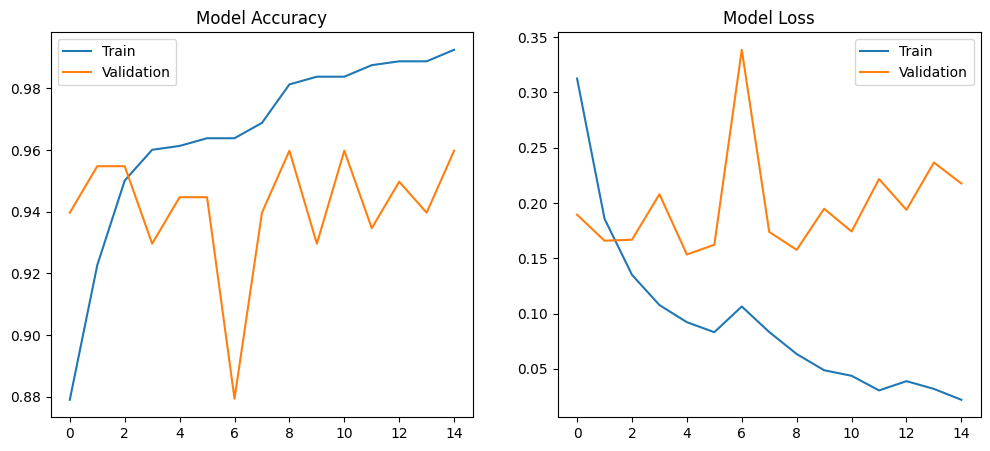

In [14]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.legend(["Train", "Validation"])

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.legend(["Train", "Validation"])

plt.show()

In [15]:
val_gen_cm = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode="binary",
    subset="validation",
    shuffle=False
)
y_true = val_gen_cm.classes   # array of 0s and 1s
class_labels = list(val_gen_cm.class_indices.keys())
print("Class labels:", class_labels)

y_pred_prob = model.predict(val_gen_cm)
y_pred = (y_pred_prob > 0.5).astype("int32")  # convert to 0/1

Found 199 images belonging to 2 classes.
Class labels: ['fire_images', 'non_fire_images']
199/199 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step


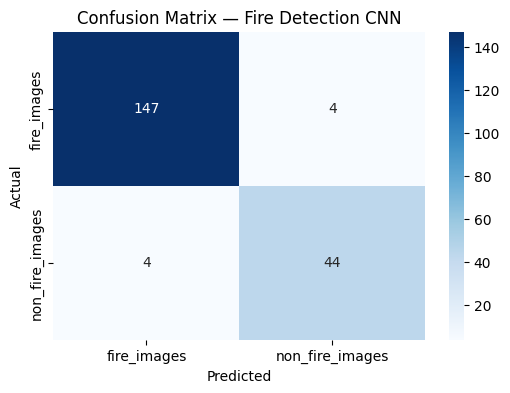


Classification Report:

                 precision    recall  f1-score   support

    fire_images       0.97      0.97      0.97       151
non_fire_images       0.92      0.92      0.92        48

       accuracy                           0.96       199
      macro avg       0.95      0.95      0.95       199
   weighted avg       0.96      0.96      0.96       199



In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Fire Detection CNN")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

 The confusion matrix for the enhanced model shows that, although the model correctly identifies a good number of fire images, it still struggles to accurately classify non-fire images and mislabels several samples. This imbalance between true positives and true negatives indicates that the model is still not generalizing well to unseen data. The presence of significant misclassifications suggests that the enhanced model needs further improvement in feature extraction and class separation to achieve reliable fire and non-fire detection.

In [17]:
tn, fp, fn, tp = cm.ravel()

fire_recall = tp / (tp + fn)
nonfire_recall = tn / (tn + fp)

print("🔥 Fire Recall (true positive rate): ", fire_recall)
print("🌿 Non-Fire Recall (true negative rate): ", nonfire_recall)

🔥 Fire Recall (true positive rate):  0.9166666666666666
🌿 Non-Fire Recall (true negative rate):  0.9735099337748344


## Predictions and Results

In [18]:
from tensorflow.keras.preprocessing import image

def predict_image(path):
    img = image.load_img(path, target_size=IMG_SIZE)
    img_arr = image.img_to_array(img) / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    prob = model.predict(img_arr)[0][0]
    pred_class = int(prob > 0.5)
    folder_name = idx_to_label[pred_class]

    plt.imshow(img)
    plt.axis("off")

    if "fire" in folder_name:
        plt.title(f"🔥 FIRE DETECTED (prob={prob:.2f})")
    else:
        plt.title(f"🌿 NON-FIRE (prob={prob:.2f})")

    plt.show()

## Model Saving

In [21]:
model.save("fire_detection_cnn") #filepath